## Import Modules

In [ ]:
%%capture
!pip install tensorflow_model_optimization

In [ ]:
import os
import re
from collections import defaultdict
import shutil
import json
import random
from ast import literal_eval

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.collections import LineCollection

import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import mean_squared_error

from sklearn.model_selection import train_test_split

import tensorflow_model_optimization as tfmot
import tensorflow as tf
from tqdm.notebook import tqdm

### Helper functions

In [ ]:
def read_image(img_loc: str, channel: "gray or rgb"="gray"):
    channel = channel.lower()
    assert channel in ["gray", "rgb"]
    image = cv2.imread(img_loc)
    if channel == "rgb":
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=-1)
        height, width, channel = image.shape
    return image

In [ ]:
def display_image(image: "image_loc or numpy.ndarray", ratio:int=5, **kwargs):
    assert isinstance(image, str) or isinstance(image, np.ndarray)
    channel = kwargs.get("channel", "gray")
    if isinstance(image, str):
        image = read_image(image, channel)
#     else:
#         if channel == "gray": image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    assert isinstance(image, np.ndarray)
    height, width = image.shape[0], image.shape[1]
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(ratio*aspect_ratio, ratio))
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')
    cmap = channel if channel == "gray" else "viridis"
    ax.imshow(image, cmap=cmap)
    return ax

In [ ]:
def get_line_segments(x):
    groups = [
        ["left_shoulder", "left_elbow"],
        ["left_elbow", "left_wrist"],
        ["right_shoulder", "right_elbow"],
        ["right_elbow", "right_wrist"],
        ["left_ankle", "left_knee"],
        ["left_knee", "left_hip"],
        ["right_ankle", "right_knee"],
        ["right_knee", "right_hip"],
        ["left_shoulder", "right_shoulder"],
        ["left_hip", "right_hip"]
    ]
    
    lines = []
    for i in groups:
        if x[i[0]][0] != -1 and x[i[1]][0] != -1:
            lines.append([x[i[0]], x[i[1]]])
    if x[groups[-2][0]][0] != -1 and x[groups[-2][1]][0] != -1:
        if x[groups[-1][0]][0] != -1 and x[groups[-1][1]][0] != -1:
            lines.append([
                [(x[groups[-2][0]][0] + x[groups[-2][1]][0])/2, (x[groups[-2][0]][1] + x[groups[-2][1]][1])/2],
                [(x[groups[-1][0]][0] + x[groups[-1][1]][0])/2, (x[groups[-1][0]][1] + x[groups[-1][1]][1])/2]
            ])
    return lines

In [ ]:
def display_image_with_pose(image: "image_loc or numpy.ndarray", pose: "pandas.core.frame.DataFrame", ratio:int=5, **kwargs):
    ax = display_image(image, ratio, **kwargs)
    line_segments = LineCollection([], linewidths=(3), linestyle='solid', color='red')
    ax.add_collection(line_segments)
    temp = get_line_segments(pose)
#     temp = pose.apply(lambda x: get_line_segments(x), axis=1).to_list()[0]
    dots = list(set((j[0], j[1]) for i in temp for j in i))
    line_segments.set_segments(temp)
    for i in dots:
        plt.scatter(i[0], i[1], s=20, zorder=3, color='white')
    return ax

In [ ]:
def datapoint_correction(x):
    temp = []
    for i in x:
        if i[0] == -1 or i[1] == -1:
            temp.append((-1, -1))
        else:
            temp.append(i)
    return pd.Series(temp)

### Define variables and directories

In [ ]:
BASE_DIR = "/content/drive/MyDrive/CNN/Regressor"
DATA_DIR = os.path.join(BASE_DIR, "data")
INPUT_DIR = os.path.join(DATA_DIR, "inputs", "gray_ch_1_224")
ANNOTATION = os.path.join(INPUT_DIR.replace("inputs", "annotations"), "final_model_ready_dataset.csv")

### Load feature space and labels

In [ ]:
X_data = np.load(os.path.join(INPUT_DIR, "X_data.npy"))
Y_data = np.load(os.path.join(INPUT_DIR, "Y_data.npy"))

### Perform preprocessing before passing to model for training

In [ ]:
# If input has one channel, repeat the channel value 3 times - for 3 channel input
if X_data.shape[-1] == 1:
    X_data = np.repeat(X_data, 3, axis=-1)

# Normalize the keypoint coordinates between 0 and 1
# if Y_data.dtype == int:
#     Y_data = Y_data/X_data.shape[1]

# Reshape Y to match output shape
Y_data = Y_data.reshape((Y_data.shape[0], 1, 1, Y_data.shape[-1]))

print("INPUT SHAPE:", X_data.shape, "\nOUTPUT_SHAPE:", Y_data.shape)

INPUT SHAPE: (11232, 224, 224, 3) 
OUTPUT_SHAPE: (11232, 1, 1, 24)


## Split dataset into train and test set

In [ ]:
X_data = (X_data/255).astype('float16')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=2022)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
del X_data, Y_data

## Define model's parameters and hyperparameters

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 500

## POSE ESTIMATOR MODEL

### Define model architecture

In [ ]:
# model = Sequential([
#                     Input(shape=X_train.shape[1:], name="INPUT"),
#                     Conv2D(filters=32, kernel_size=[5,5],padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
                    
#                     Conv2D(filters=32, kernel_size=[5,5], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     MaxPool2D(pool_size=[2,2]),
                    
#                     Conv2D(filters=64, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     Conv2D(filters=64, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     MaxPool2D(pool_size=[2,2]),
                    
#                     Conv2D(filters=128, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     Conv2D(filters=128, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     MaxPool2D(pool_size=[2,2]),
                    
#                     Conv2D(filters=256, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     Conv2D(filters=256, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     MaxPool2D(pool_size=[2,2]),
                    
#                     Conv2D(filters=512, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
#                     Conv2D(filters=512, kernel_size=[3,3], padding='same', use_bias=False),
#                     LeakyReLU(alpha = .1),
#                     BatchNormalization(),
                    
#                     Flatten(),
#                     Dense(units=512, activation='relu'),
#                     Dropout(.1),
#                     Dense(units=Y_test.shape[-1]),
# ], name="Pose_Estimator")
# model.summary()

In [ ]:
backbone = tf.keras.applications.MobileNetV3Small(input_shape = X_train.shape[1:], minimalistic=True, weights='imagenet', include_top=False, include_preprocessing=False, pooling=None)
backbone.trainable = True

inputs = Input(shape=X_train.shape[1:], name="INPUT")
x = backbone(inputs)
x

2138112/2128592 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 7, 7, 576) dtype=float32 (created by layer 'MobilenetV3small')>

In [ ]:
x = tf.keras.layers.SeparableConv2D(256, kernel_size=5, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(64, kernel_size=3, strides=1, activation="relu")(x)
outputs = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Pose_Estimator")

In [ ]:
# backbone = tf.keras.applications.MobileNetV3Large(input_shape = X_train.shape[1:], weights='imagenet', include_top=False, include_preprocessing=False)
# backbone.trainable = False

# inputs = Input(shape=X_train.shape[1:], name="INPUT")
# # x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
# x = backbone(inputs)
# x = Dropout(0.3)(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# outputs = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Pose_Estimator")

In [ ]:
# backbone = tf.keras.applications.MobileNetV3Large(input_shape = X_train.shape[1:], weights='imagenet', include_top=False)
# backbone.trainable = False

# inputs = Input(shape=X_train.shape[1:], name="INPUT")
# x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
# x = backbone(x)
# x = Dropout(0.3)(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=5, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# outputs = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=2, strides=1, activation="sigmoid")(x)
# model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Pose_Estimator")


# inputs = Input(shape=X_train.shape[1:], name="INPUT")
# # x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
# x = backbone(inputs)
# x = Dropout(0.3)(x)
# # x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=5, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=3, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=1, strides=1, activation="relu")(x)
# x = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=1, strides=1, activation="relu")(x)
# outputs = tf.keras.layers.SeparableConv2D(Y_train.shape[-1], kernel_size=1, strides=1, activation="relu")(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Pose_Estimator")
# model.summary()

In [ ]:
model.summary()

Model: "Pose_Estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        441000    
 l)                                                              
                                                                 
 separable_conv2d (Separable  (None, 3, 3, 256)        162112    
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 1, 1, 24)         8472      
 leConv2D)                                                       
                                                                 
Total params: 611,584
Trainable params: 599,472
Non-trainable params: 12,112
_________________________________________

### Plot model

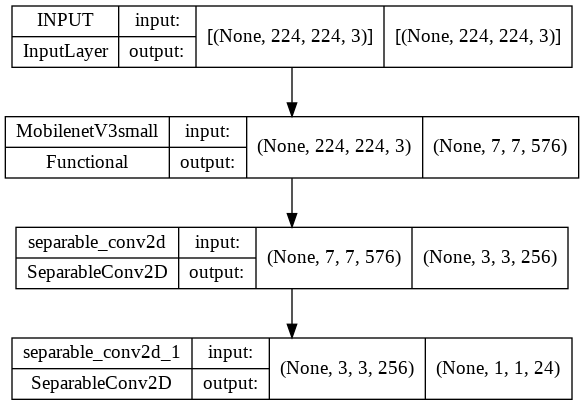

In [ ]:
plot_model(model, show_shapes=True)

### Compile model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.mean_squared_error,
    # metrics=['mae', 'mape',],
    metrics=['mae'],
)

### Define callbacks

In [ ]:
CALLBACKS = [ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=8,
    verbose=1,
    min_lr=LEARNING_RATE*1e-5,
    mode='auto',
    cooldown=0,
    min_delta=0.0001
)]
CALLBACKS += [EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)]

### Train and evaluate model

In [ ]:
# Y_train = Y_train.reshape(Y_train.shape[0], 1, 1, Y_train.shape[-1])
# Y_test = Y_test.reshape(Y_test.shape[0], 1, 1, Y_test.shape[-1])

In [ ]:
history = model.fit(X_train, Y_train,
                    epochs = EPOCHS,
                    validation_data = (X_test, Y_test),
                    batch_size = BATCH_SIZE,
                    callbacks = [CALLBACKS],
                    )

Epoch 1/500
141/141 [==============================] - 24s 76ms/step - loss: 12934.6074 - mae: 107.5948 - val_loss: 4684.5879 - val_mae: 55.3683 - lr: 1.0000e-04
Epoch 2/500
141/141 [==============================] - 8s 58ms/step - loss: 2103.1946 - mae: 34.4569 - val_loss: 68768.1016 - val_mae: 246.5346 - lr: 1.0000e-04
Epoch 3/500
141/141 [==============================] - 8s 58ms/step - loss: 764.0189 - mae: 20.8843 - val_loss: 30313.2285 - val_mae: 164.5270 - lr: 1.0000e-04
Epoch 4/500
141/141 [==============================] - 8s 58ms/step - loss: 742.5297 - mae: 20.5468 - val_loss: 13546.6895 - val_mae: 108.8835 - lr: 1.0000e-04
Epoch 5/500
141/141 [==============================] - 8s 58ms/step - loss: 731.2796 - mae: 20.3937 - val_loss: 6763.2891 - val_mae: 75.3421 - lr: 1.0000e-04
Epoch 6/500
141/141 [==============================] - 8s 59ms/step - loss: 722.5052 - mae: 20.2714 - val_loss: 3766.0081 - val_mae: 54.4779 - lr: 1.0000e-04
Epoch 7/500
141/141 [====================

## Make predictions

In [ ]:
predicted = []
pbar = tqdm(total=len(X_test), desc="Making predictions: ")
for i in range(len(X_test)):
    predicted.append(model.predict(X_test[i:i+1]))
    pbar.update(1)
predicted = np.array(predicted).astype('int')
pbar.close()

Making predictions:   0%|          | 0/2247 [00:00<?, ?it/s]

In [ ]:
# new_pred = (predicted * X_test.shape[1]).astype('int')
new_pred = predicted.astype('int')
new_pred = np.where(new_pred < 1, -1, new_pred)
new_pred = new_pred.reshape((new_pred.shape[0], new_pred.shape[-1]))
new_pred.shape

(2247, 24)

In [ ]:
data = []
for i in new_pred:
    temp = i.tolist()
    data.append([(temp[j], temp[j+1]) for j in range(0, 24, 2)])

pd_test = pd.DataFrame(data)
columns = pd.read_csv(ANNOTATION).columns[1:-7]
pd_test.columns = columns

pd_test = pd_test.apply(lambda x: datapoint_correction(x), axis=1)
pd_test.columns = columns
pd_test.head()

,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle
0,"(96, 99)","(84, 100)","(99, 121)","(84, 121)","(100, 129)","(86, 130)","(98, 133)","(89, 133)","(103, 147)","(92, 146)","(104, 162)","(95, 164)"
1,"(118, 123)","(114, 123)","(120, 140)","(114, 140)","(116, 149)","(113, 147)","(119, 145)","(117, 145)","(118, 156)","(115, 156)","(118, 171)","(116, 171)"
2,"(113, 110)","(101, 109)","(115, 129)","(100, 128)","(114, 138)","(101, 137)","(113, 133)","(108, 133)","(116, 141)","(105, 140)","(113, 152)","(107, 153)"
3,"(129, 46)","(109, 46)","(131, 69)","(103, 69)","(128, 79)","(105, 76)","(124, 99)","(110, 100)","(124, 144)","(108, 144)","(124, 188)","(106, 187)"
4,"(129, 67)","(108, 66)","(131, 93)","(103, 90)","(127, 105)","(103, 101)","(127, 110)","(114, 109)","(127, 133)","(108, 132)","(123, 160)","(108, 161)"


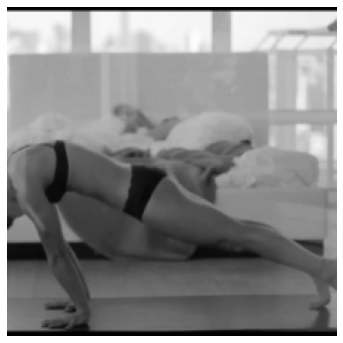

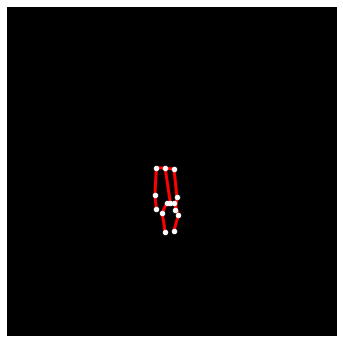

In [ ]:
i = 2
# display_image_with_pose(np.repeat(X_train[i], 3, axis=-1), temp_data.iloc[i])
display_image((X_test[i]*255).astype('int'))
display_image_with_pose(np.zeros(224*224*3).reshape(224,224,3).astype('int'), pd_test.iloc[i])

In [ ]:
from sklearn.metrics import mean_absolute_error

print('Baseline test mae:', mean_absolute_error(Y_test.reshape(Y_test.shape[0], Y_test.shape[-1]), new_pred))

Baseline test mae: 17.238076694852396


In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

prune_epochs = 10

end_step = np.ceil(1.0 * X_train.shape[0] / BATCH_SIZE).astype(np.int32) * prune_epochs
# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.50,
        final_sparsity=0.95,
        begin_step=0,
        end_step=end_step
        ),
    }
model_for_pruning = prune_low_magnitude(model, **pruning_params)
# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(
    loss = 'mse',
    optimizer = Adam(),
    metrics = ['mae'],
)

model_for_pruning.summary()

pruning_history = model_for_pruning.fit(X_train, Y_train,
                    epochs=prune_epochs,
                    validation_data=(X_test, Y_test), 
                    # batch_size=BATCH_SIZE,
                    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
                    )
model_for_pruning.save("pruned_multiclass")

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Model: "Pose_Estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        835796    
 l)                                                              
                                                                 
 prune_low_magnitude_separab  (None, 3, 3, 256)        309570    
 le_conv2d (PruneLowMagnitud                                     
 e)                                                              
                                                                 
 prune_low_magnitude_separab  (None, 1, 1, 24)         14618     
 le_conv2d_1 (PruneLowMagnit                                     
 ude)                                                            
                                                    

INFO:tensorflow:Assets written to: pruned_multiclass/assets


INFO:tensorflow:Assets written to: pruned_multiclass/assets


In [ ]:
prun_pred = model_for_pruning.predict(X_test)
prun_pred = prun_pred.astype('int')
prun_pred = np.where(prun_pred < 1, -1, prun_pred)
prun_pred = prun_pred.reshape((prun_pred.shape[0], prun_pred.shape[-1]))
prun_pred.shape

(2247, 24)

In [ ]:
print('Baseline test mae:', mean_absolute_error(Y_test.reshape(Y_test.shape[0], Y_test.shape[-1]), new_pred))
print('Pruned test mae:', mean_absolute_error(Y_test.reshape(Y_test.shape[0], Y_test.shape[-1]), prun_pred))

Baseline test mae: 17.238076694852396
Pruned test mae: 63.89613929684023


In [ ]:
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train/255).astype('float32'))

# get the pruned model ready
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

# quantize
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

num_calibration_steps = 1
def representative_data_gen():
    for input_value in X_train_dataset.batch(1).take(100):
        yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

In [ ]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpixwoevpb/assets


INFO:tensorflow:Assets written to: /tmp/tmpixwoevpb/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
with open("quant_pruned.tflite",'wb') as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter("quant_pruned.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
quant_pred = []

pbar = tqdm(total=len(X_test), desc="Making predictions on tflite model:")
for i in range(len(X_test)):
    input_data = np.expand_dims((X_test[0]*255).astype('int8'), axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    pbar.update(1)
    
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    quant_pred.append(output_data.flatten())
quant_pred = np.array(quant_pred)
pbar.close()

Making predictions on tflite model::   0%|          | 0/2247 [00:00<?, ?it/s]

In [ ]:
print('Baseline test mae:', mean_absolute_error(Y_test.reshape(Y_test.shape[0], Y_test.shape[-1]), new_pred))
print('Pruned test mae:', mean_absolute_error(Y_test.reshape(Y_test.shape[0], Y_test.shape[-1]), prun_pred))
print('Quantized test mae:', mean_absolute_error(Y_test.reshape(Y_test.shape[0], Y_test.shape[-1]), quant_pred))

Baseline test mae: 17.238076694852396
Pruned test mae: 63.89613929684023
Quantized test mae: 149.2972852692479


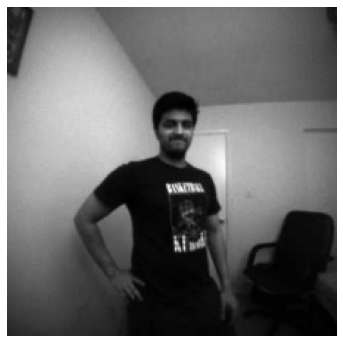

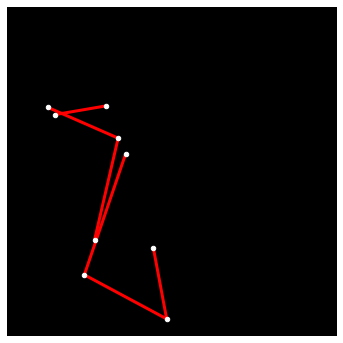

In [ ]:
port_img = cv2.resize(cv2.imread("me/00006.jpg"), (224, 224), interpolation=cv2.INTER_AREA)
port_pred = model.predict(np.expand_dims(port_img, axis=0)).astype('int').flatten()
port_pred = np.where(port_pred < 1, -1, port_pred)
port_pred = np.where(port_pred > 224, -1, port_pred)

data = []
for i in [port_pred]:
    temp = i.tolist()
    data.append([(temp[j], temp[j+1]) for j in range(0, 24, 2)])

pd_test = pd.DataFrame(data)
columns = pd.read_csv(ANNOTATION).columns[1:-7]
pd_test.columns = columns

pd_test = pd_test.apply(lambda x: datapoint_correction(x), axis=1)
pd_test.columns = columns
display_image(port_img)
display_image_with_pose(np.zeros(224*224*3).reshape(224,224,3).astype('int'), pd_test.iloc[0], ratio=5)